In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns

In [2]:
ftalany = pd.read_excel('ftalany.xlsx', sheet_name=['X_train', 'y_train', 'X_test', 'y_test'])
scaler = StandardScaler()
Xt = ftalany['X_train']
Yt = ftalany['y_train']
Xv = ftalany['X_test']
Yv = ftalany['y_test']
Xt = Xt.rename(columns={"qc-": "qc"})

In [3]:
metrics = ['euclidean', 'manhattan', 'chebyshev', 'canberra']
rmse_cv_scores = {}
cv = KFold(n_splits = 23, shuffle = True, random_state = 1)

for metric in metrics:
    rmse_cv_scores[metric] = []
    for k in range(2, 23):
        knn_model = KNeighborsRegressor(n_neighbors=k, metric=metric)
        mse_scores = cross_val_score(knn_model, Xt, Yt, cv=cv, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-mse_scores.mean())
        rmse_cv_scores[metric].append(rmse)


Wybieram wartość n_splits równą 23 (tyle ile próbek w zbiorze treningowym) ze względu na małą ilość próbek.

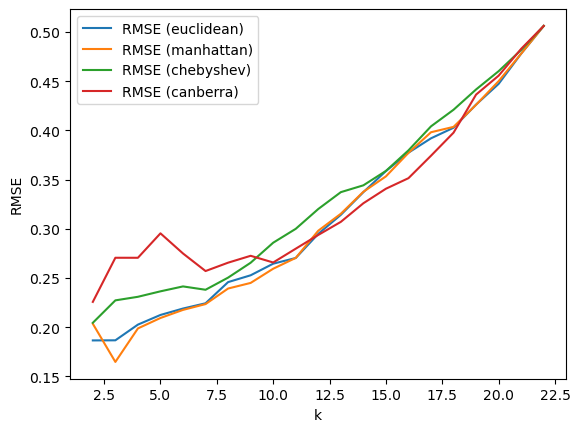

In [4]:
for metric in rmse_cv_scores:
    plt.plot(range(2, 23), rmse_cv_scores[metric], label=f'RMSE ({metric})')
plt.legend()
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

Według wykresu oraz wyliczonych wartości RMSE powinnam wybrać wartość k = 2 lub 3. Ze względu na regułę nieparzystości wybieram k = 3.

In [19]:
def knn_stats(metric):
    """
    Evaluate K-Nearest Neighbors (KNN) regression model performance using specified metric.

    Parameters:
    metric (str): The distance metric to use for the KNN algorithm. Examples include 'euclidean', 'manhattan', etc.

    Returns:
    str: A formatted string containing the following performance metrics:
        - R2: Coefficient of determination (R-squared) for the training set.
        - RMSEc: Root Mean Squared Error for the training set.
        - Q2ext: Coefficient of determination (R-squared) for the validation set.
        - RMSEext: Root Mean Squared Error for the validation set.
    """
    knn = KNeighborsRegressor(n_neighbors=3, metric=metric)
    knn.fit(Xt, Yt)
    y_pred_t = knn.predict(Xt)
    y_pred_v = knn.predict(Xv)
    R2 = r2_score(y_pred_t, Yt)
    RMSEc = root_mean_squared_error(y_pred_t, Yt)
    Q2ext = r2_score(y_pred_v, Yv)
    RMSEext = root_mean_squared_error(y_pred_v, Yv)
    return (f'R2 = {R2}\n RMSEc = {RMSEc}\n Q2ext = {Q2ext}\n RMSEext = {RMSEext}')

R2_list = []
RMSEc_list = []
Q2ext_list = []
RMSEext_list = []

for i in ('manhattan', 'euclidean', 'chebyshev', 'canberra'):
    stats = knn_stats(i).split('\n')
    R2_list.append(float(stats[0].split('=')[1].strip()))
    RMSEc_list.append(float(stats[1].split('=')[1].strip()))
    Q2ext_list.append(float(stats[2].split('=')[1].strip()))
    RMSEext_list.append(float(stats[3].split('=')[1].strip()))
    print(f'For {i} method scores are:')
    for j in range(0, len(stats), 4):
        print(' | '.join(stats[j:j+4]))
    print()

# Calculate and print the averages
avg_R2 = np.mean(R2_list)
avg_RMSEc = np.mean(RMSEc_list)
avg_Q2ext = np.mean(Q2ext_list)
avg_RMSEext = np.mean(RMSEext_list)

print(f'Average R2 = {avg_R2}')
print(f'Average RMSEc = {avg_RMSEc}')
print(f'Average Q2ext = {avg_Q2ext}')
print(f'Average RMSEext = {avg_RMSEext}')

For manhattan method scores are:
R2 = 0.922127322440345 |  RMSEc = 0.1356149908704501 |  Q2ext = 0.883164614053437 |  RMSEext = 0.13547316302956303

For euclidean method scores are:
R2 = 0.9308795530186199 |  RMSEc = 0.12432545551450391 |  Q2ext = 0.8681824452818329 |  RMSEext = 0.12996238772130267

For chebyshev method scores are:
R2 = 0.8961368044593706 |  RMSEc = 0.1362759320710585 |  Q2ext = 0.7518295473882896 |  RMSEext = 0.15804701597707957

For canberra method scores are:
R2 = 0.9075676846930225 |  RMSEc = 0.15044275910829322 |  Q2ext = 0.9339222539220708 |  RMSEext = 0.10513809085268826

Average R2 = 0.9141778411528395
Average RMSEc = 0.13666478439107643
Average Q2ext = 0.8592747151614076
Average RMSEext = 0.13215516439515837


Statystyki dla zwykłego KNN oscylują $R^2$ \~ 0.9-0.93; $RMSE_c$ \~ 0.12-0.15; $Q^2_{ext}$ \~ 0.75-0.93; $RMSE_{ext}$ \~ 0.10-0.16. Modele radzą sobie stosunkowo dobrze, najlepsze statystyki dla zbioru walidacyjnego ma model Canberra (najwyższe $Q^2_{ext}$ i najniższe $RMSE_{ext}$).

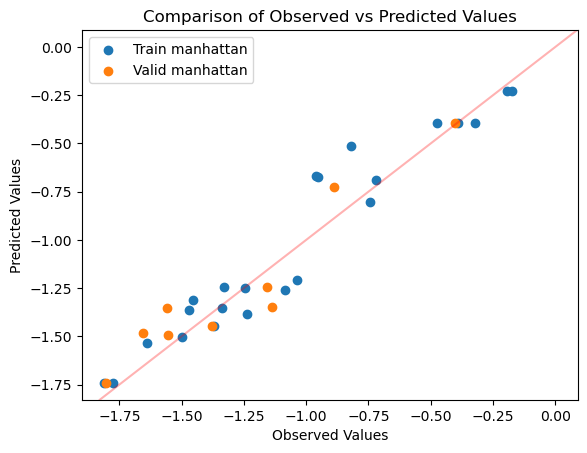

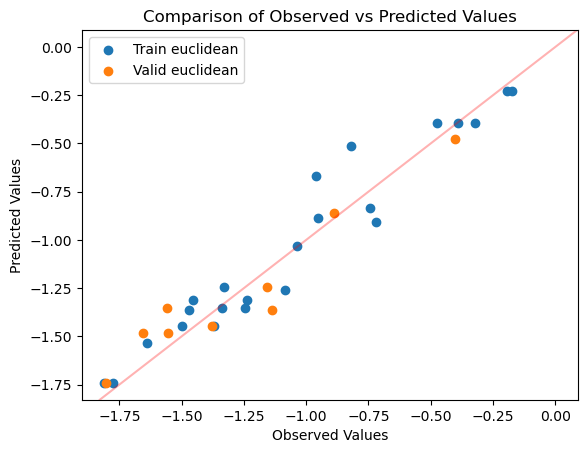

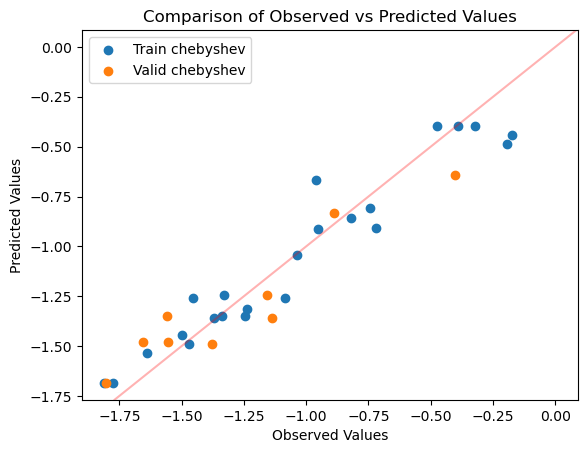

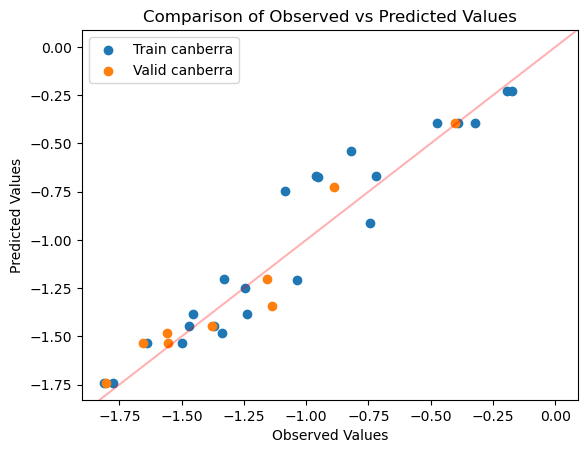

In [6]:
# Scatter plot of training and test predictions
for metric in ('manhattan', 'euclidean', 'chebyshev', 'canberra'):
    knn = KNeighborsRegressor(n_neighbors=3, metric=metric)
    knn.fit(Xt, Yt)
    y_pred_t = knn.predict(Xt)
    y_pred_v = knn.predict(Xv)
    plt.scatter(Yt, y_pred_t, label=f'Train {metric}')
    plt.scatter(Yv, y_pred_v, label=f'Valid {metric}')

    # Add legend
    plt.legend()

    # Add a diagonal line for reference
    plt.axline((0, 0), slope=1, color="red", alpha=0.3)

    # Add title and labels
    plt.title("Comparison of Observed vs Predicted Values")
    plt.xlabel("Observed Values")
    plt.ylabel("Predicted Values")

    # Show plot
    plt.show()


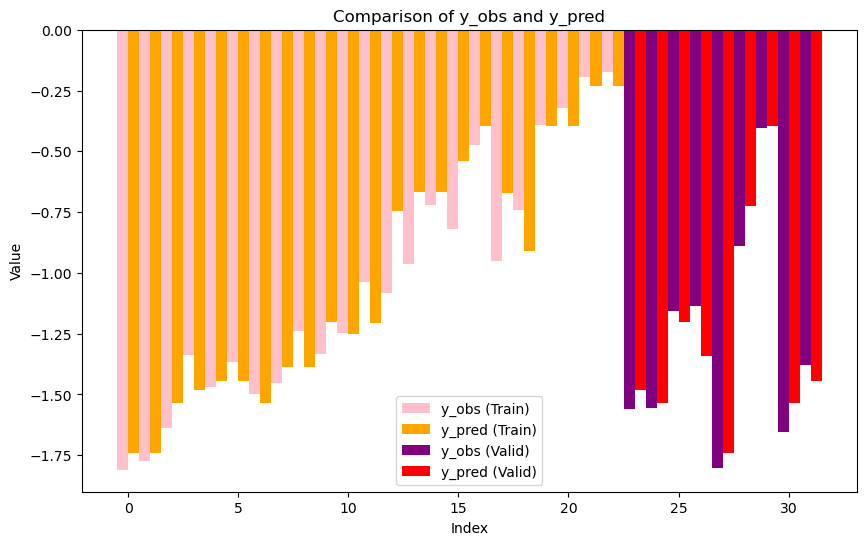

In [7]:
# Convert y_pred and y_obs to 1D arrays for easier plotting
y_pred_training_flat = y_pred_t.flatten()
y_obs_training_flat = Yt.squeeze().to_numpy()
y_pred_test_flat = y_pred_v.flatten()
y_obs_test_flat = Yv.squeeze().to_numpy()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.5  # the width of the bars

# Plot y_obs and y_pred for training data side by side
ax.bar(np.arange(len(y_obs_training_flat)) - width/2, y_obs_training_flat, width, label='y_obs (Train)', color='pink')
ax.bar(np.arange(len(y_obs_training_flat)) + width/2, y_pred_training_flat, width, label='y_pred (Train)', color='orange')

# Plot y_obs and y_pred for test data side by side
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) - width/2, y_obs_test_flat, width, label='y_obs (Valid)', color='purple')
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) + width/2, y_pred_test_flat, width, label='y_pred (Valid)', color='red')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of y_obs and y_pred')
ax.legend()

plt.show()

In [8]:
def knn_model_metrics_bar_comparision(weighted: bool) -> None:
    """
    Plots bar charts comparing KNN model metrics for different distance metrics.

    This function trains a K-Nearest Neighbors (KNN) regression model using different distance metrics
    and plots bar charts to compare the following metrics:
    - R2 (coefficient of determination) for training data
    - RMSE (Root Mean Squared Error) for training data
    - Q2 (coefficient of determination) for validation data
    - RMSE for validation data
    - Difference between R2 and Q2

    Parameters:
    weighted (bool): If True, the KNN model uses distance-weighted neighbors. If False, it uses uniform weights.

    Returns:
    None
    """
    metrics = ("euclidean", "manhattan", "chebyshev", "canberra")
    colors = sns.color_palette("flare", len(metrics))
    R2_values = []
    RMSEc_values = []
    Q2ext_values = []
    RMSEext_values = []
    diff_R2_Q2 = []

    for metric in metrics:
        if weighted:
            knn_model = KNeighborsRegressor(n_neighbors=3, metric=metric, weights='distance')
        else:
            knn_model = KNeighborsRegressor(n_neighbors=3, metric=metric)
        knn_model_fit = knn_model.fit(Xt, Yt)

        y_pred_train = knn_model_fit.predict(Xt)
        y_pred_valid = knn_model_fit.predict(Xv)

        R2 = r2_score(y_pred_train.flatten(), Yt)
        Q2 = r2_score(y_pred_valid.flatten(), Yv)

        R2_values.append(R2)
        RMSEc_values.append(root_mean_squared_error(y_pred_train.flatten(), Yt))
        Q2ext_values.append(Q2)
        RMSEext_values.append(root_mean_squared_error(y_pred_valid.flatten(), Yv))
        diff_R2_Q2.append(R2 - Q2)

    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    # Plot R2 for training data
    axs[0, 0].bar(metrics, R2_values, color=colors)
    axs[0, 0].set_title('R2 (Train)')
    axs[0, 0].set_ylabel('R2')

    # Plot RMSE for training data
    axs[0, 1].bar(metrics, RMSEc_values, color=colors)
    axs[0, 1].set_title('RMSE (Train)')
    axs[0, 1].set_ylabel('RMSE')

    # Plot Q2 for test data
    axs[1, 0].bar(metrics, Q2ext_values, color=colors)
    axs[1, 0].set_title('Q2 (Valid)')
    axs[1, 0].set_ylabel('Q2')

    # Plot RMSE for test data
    axs[1, 1].bar(metrics, RMSEext_values, color=colors)
    axs[1, 1].set_title('RMSE (Valid)')
    axs[1, 1].set_ylabel('RMSE')

    # Plot difference between R2 and Q2
    axs[2, 0].bar(metrics, diff_R2_Q2, color=colors)
    axs[2, 0].set_title('Difference between R2 and Q2')
    axs[2, 0].set_ylabel('R2 - Q2')

    # Hide the empty subplot
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

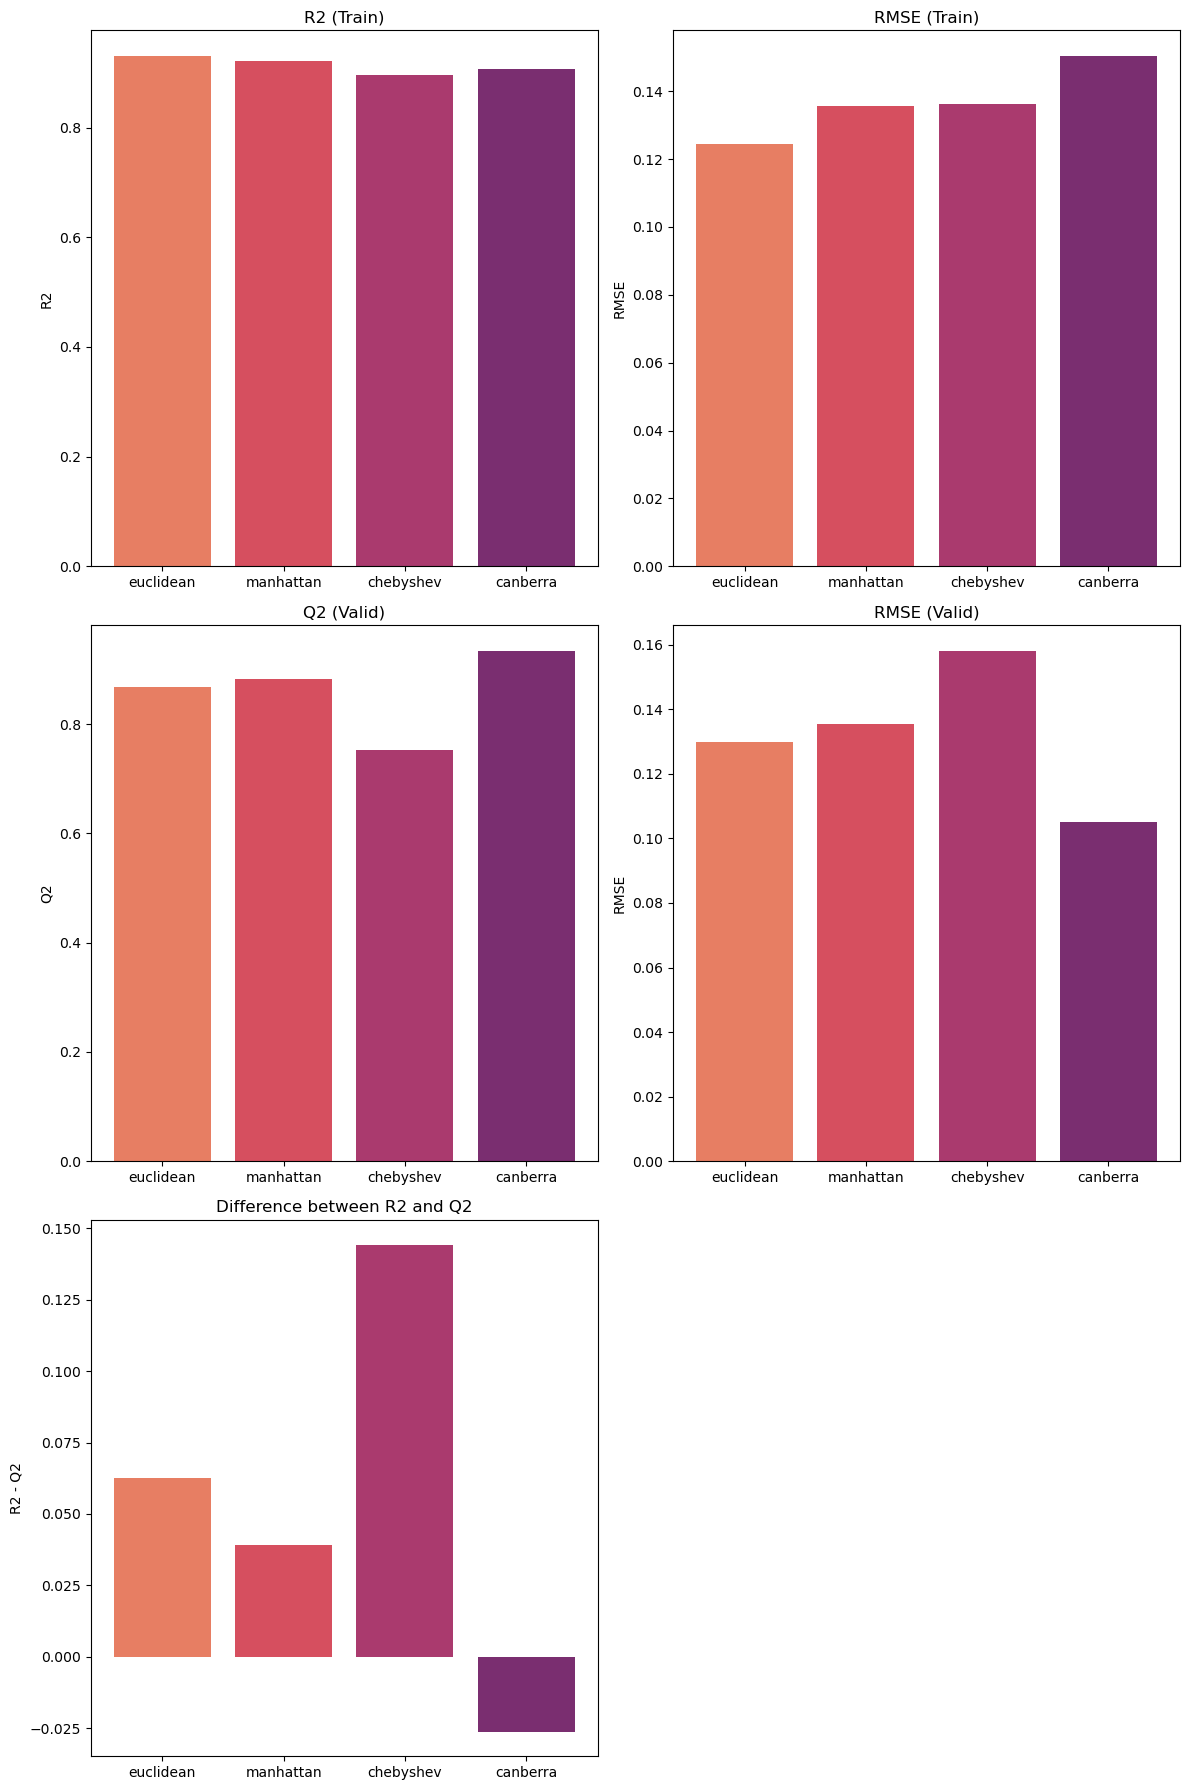

In [9]:
knn_model_metrics_bar_comparision(weighted=False)

In [18]:
def knn_stats_weighted(metric):
    knn = KNeighborsRegressor(n_neighbors=3, metric=metric, weights='distance')
    knn.fit(Xt, Yt)
    y_pred_t = knn.predict(Xt)
    y_pred_v = knn.predict(Xv)
    R2 = r2_score(y_pred_t, Yt)
    RMSEc = root_mean_squared_error(y_pred_t, Yt)
    Q2ext = r2_score(y_pred_v, Yv)
    RMSEext = root_mean_squared_error(y_pred_v, Yv)
    return R2, RMSEc, Q2ext, RMSEext

metrics = ['manhattan', 'euclidean', 'chebyshev', 'canberra']
R2_list = []
RMSEc_list = []
Q2ext_list = []
RMSEext_list = []

for metric in metrics:
    R2, RMSEc, Q2ext, RMSEext = knn_stats_weighted(metric)
    R2_list.append(R2)
    RMSEc_list.append(RMSEc)
    Q2ext_list.append(Q2ext)
    RMSEext_list.append(RMSEext)
    print(f'For {metric} method scores are:')
    print(f'R2 = {R2} | RMSEc = {RMSEc} | Q2ext = {Q2ext} | RMSEext = {RMSEext}\n')

# Calculate and print the averages
avg_R2 = np.mean(R2_list)
avg_RMSEc = np.mean(RMSEc_list)
avg_Q2ext = np.mean(Q2ext_list)
avg_RMSEext = np.mean(RMSEext_list)

print(f'Average R2 = {avg_R2}')
print(f'Average RMSEc = {avg_RMSEc}')
print(f'Average Q2ext = {avg_Q2ext}')
print(f'Average RMSEext = {avg_RMSEext}')

For manhattan method scores are:
R2 = 1.0 | RMSEc = 0.0 | Q2ext = 0.8935356302773477 | RMSEext = 0.12904346476815262

For euclidean method scores are:
R2 = 1.0 | RMSEc = 0.0 | Q2ext = 0.869534040707288 | RMSEext = 0.13277537302299516

For chebyshev method scores are:
R2 = 1.0 | RMSEc = 0.0 | Q2ext = 0.7862573874569132 | RMSEext = 0.1538387417665608

For canberra method scores are:
R2 = 1.0 | RMSEc = 0.0 | Q2ext = 0.9219687799751655 | RMSEext = 0.11317638421653425

Average R2 = 1.0
Average RMSEc = 0.0
Average Q2ext = 0.8678239596041786
Average RMSEext = 0.13220849094356069


Statystyki dla ważonego KNN równają się/oscylują dla $R^2$ = 1.0; $RMSE_c$ = 0.0; $Q^2_{ext}$ \~ 0.78-0.92; $RMSE_{ext}$ \~ 0.11-0.15. Modele w tym przypadku też radzą sobie stosunkowo dobrze, najlepsze statystyki dla zbioru walidacyjnego dalej ma model Canberra (najwyższe $Q^2_{ext}$ i najniższe $RMSE_{ext}$).

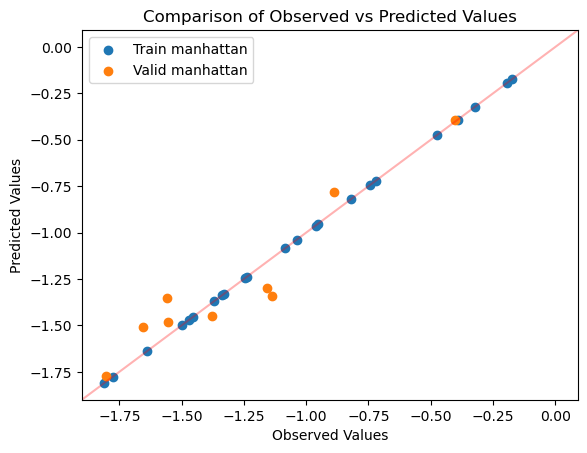

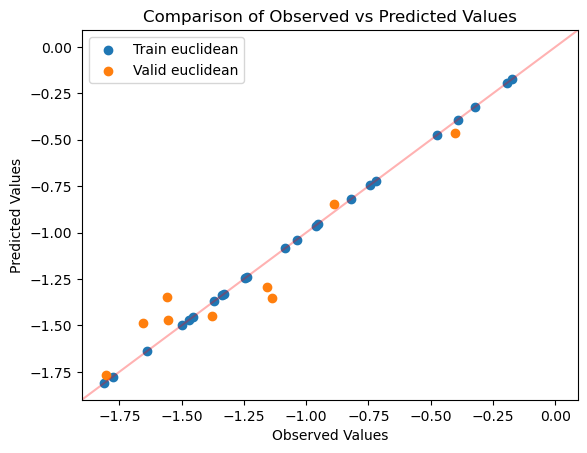

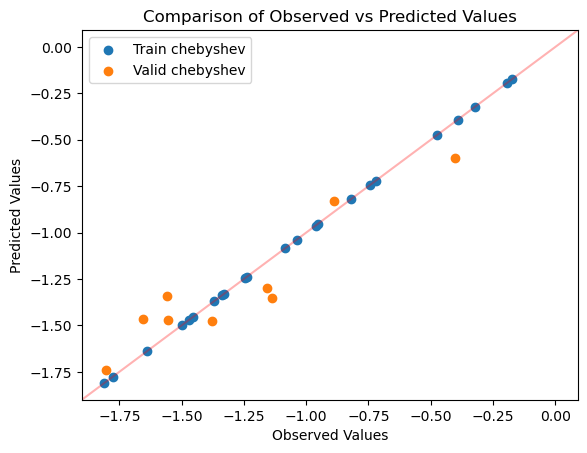

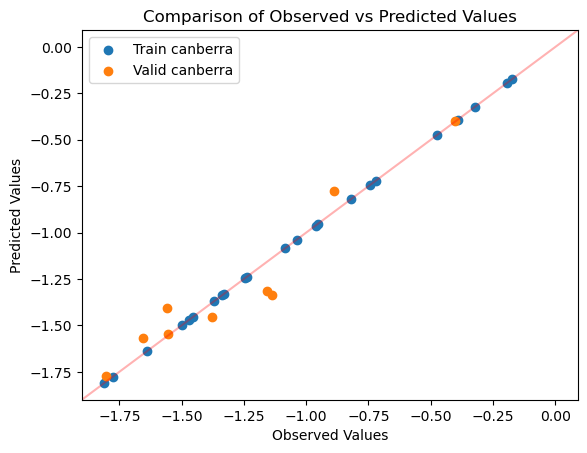

In [11]:
# Scatter plot of training and test predictions
for metric in ('manhattan', 'euclidean', 'chebyshev', 'canberra'):
    knn = KNeighborsRegressor(n_neighbors=3, metric=metric, weights='distance')
    knn.fit(Xt, Yt)
    y_pred_t = knn.predict(Xt)
    y_pred_v = knn.predict(Xv)
    plt.scatter(Yt, y_pred_t, label=f'Train {metric}')
    plt.scatter(Yv, y_pred_v, label=f'Valid {metric}')

    # Add legend
    plt.legend()

    # Add a diagonal line for reference
    plt.axline((0, 0), slope=1, color="red", alpha=0.3)

    # Add title and labels
    plt.title("Comparison of Observed vs Predicted Values")
    plt.xlabel("Observed Values")
    plt.ylabel("Predicted Values")

    # Show plot
    plt.show()

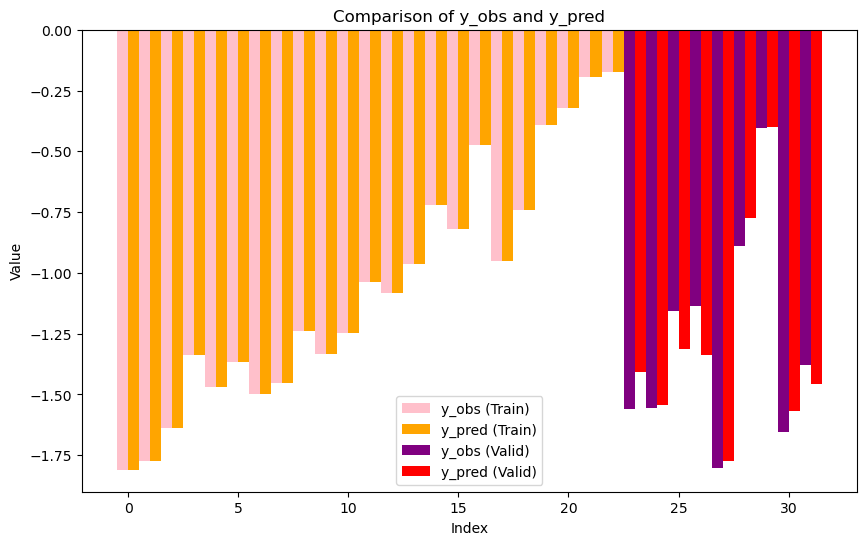

In [12]:
# Convert y_pred and y_obs to 1D arrays for easier plotting
y_pred_training_flat = y_pred_t.flatten()
y_obs_training_flat = Yt.squeeze().to_numpy()
y_pred_test_flat = y_pred_v.flatten()
y_obs_test_flat = Yv.squeeze().to_numpy()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.5  # the width of the bars

# Plot y_obs and y_pred for training data side by side
ax.bar(np.arange(len(y_obs_training_flat)) - width/2, y_obs_training_flat, width, label='y_obs (Train)', color='pink')
ax.bar(np.arange(len(y_obs_training_flat)) + width/2, y_pred_training_flat, width, label='y_pred (Train)', color='orange')

# Plot y_obs and y_pred for test data side by side
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) - width/2, y_obs_test_flat, width, label='y_obs (Valid)', color='purple')
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) + width/2, y_pred_test_flat, width, label='y_pred (Valid)', color='red')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of y_obs and y_pred')
ax.legend()

plt.show()

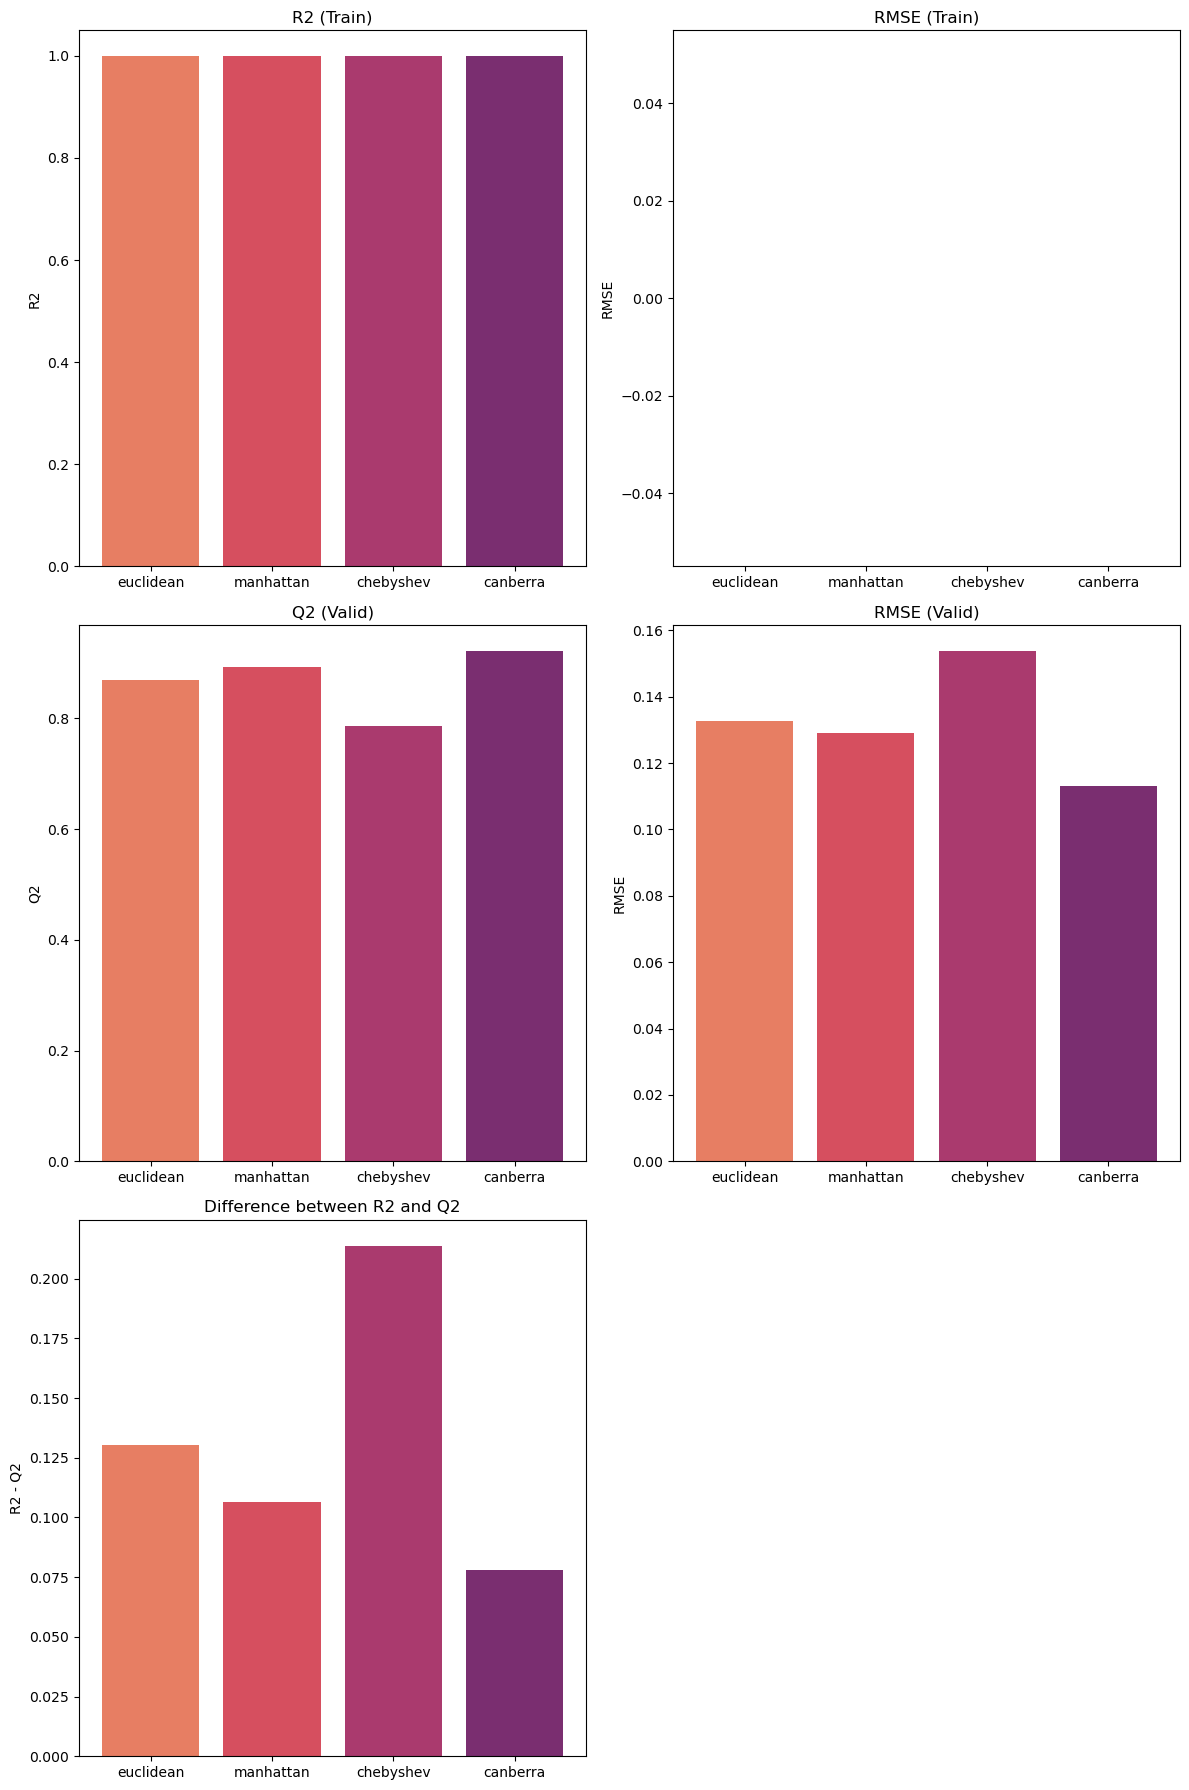

In [13]:
knn_model_metrics_bar_comparision(True)

Na pierwszy rzut oka możnaby powiedzieć, że porównując zwykłe KNN i ważone KNN to drugie poradziło sobie lepiej. Wszystkie jego statystyki $R^2$ = 1, a $RMSE_c$ = 0, ale to również implikuje, iż ważony KNN przeuczył się na zbiorze treningowym. Najlepsza metoda Canberra ma mniejsze $Q^2$ niż przy zwykłym -> z 0.93 spadło do 0.92, a $RMSE_{ext}$ wzrosło z 0.10 do 0.11. Co prawda średnia dla $Q^2$ dla ważonego KNN jest delikatnie wyższa, co nie jest wystarczającym parametrem do zignorowania innych niepokojących wyników (jak przeuczenie modelu).


Ustawiając metody w kolejności od najkorzystniejszych do najmniej korzystych według statystyk dla zbioru walidacyjnego prezentowałyby się następująco:

Canberra > Manhattan > Euclidean > Chebyshev;

co implikuje, że wybór miary odległości wpływa na końcowy model.